Wykorzystane moduły

In [40]:
from math import sin, cos, pi, factorial
import matplotlib.pyplot as plt
import numpy as np
import copy

Zadana funkcja

In [2]:
def f(x):
    return 30 + (x**2 / 1.5) - 30 * cos(1.5 * x)

Zadany przedział

In [3]:
f_range_a = -4 * pi
f_range_b = 4 * pi

Pochodna zadanej funkcji

In [41]:
def g(x):
    return 45 * sin(1.5 * x) + ( (4 * x) / 3)

Funkcja rysująca wykres funkcji

In [6]:
def plot_function(func, range_a, range_b, title, color):
    
    func_x = np.linspace(range_a, range_b, 10000)
        
    func_y = list(map(func, func_x))

    plt.plot(func_x, func_y, label = title, color = color)

    plt.legend()
    plt.grid(True)
    plt.savefig("zadana_funkcja.png")

Wykres zadanej funkcji

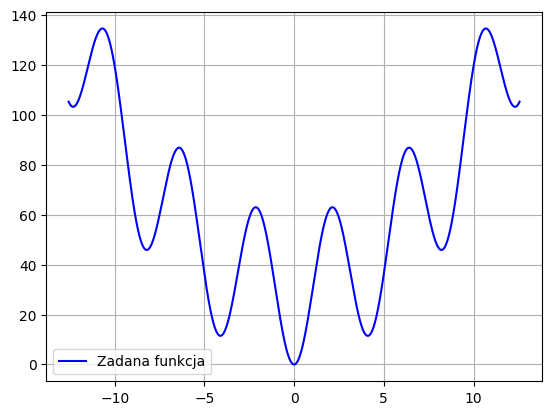

In [43]:
plot_function(f, f_range_a, f_range_b, "Zadana funkcja", "blue")

Wykres pochodnej zadanej funkcji

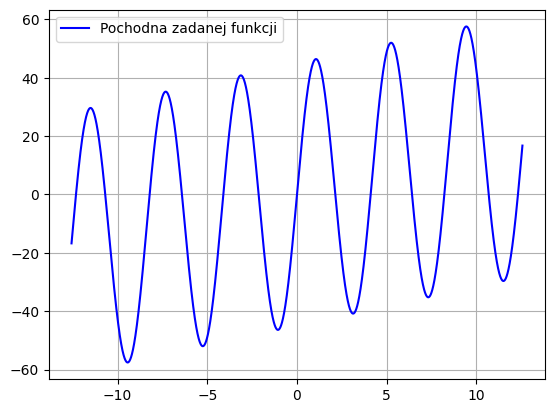

In [44]:
plot_function(g, f_range_a, f_range_b, "Pochodna zadanej funkcji", "blue")

Sposoby generacji węzłów

Węzły równoodległe

In [9]:
def get_evenly_distributed(a, b, n = 100):
    
    length = abs(b - a)
    h = length / (n - 1)
    
    return [a + i * h for i in range(n - 1)] + [b]

Węzły Czebyszewa

In [10]:
def get_chebyshev_nodes(a, b, n):

    nodes = []

    for k in range(1, n + 1):

        nodes.append( 0.5 * (a + b) + 0.5 * (b - a) *  cos( ( (2 * k - 1) / (2 * n) ) * pi ) )
    
    return nodes[::-1]

Interpolacja lagrange'a

In [11]:
def lagrange_interpolation(xs, ys, x): 

    if len(xs) != len(ys): return

    P = 0 #Value of a polynomial at point x

    for i in range(len(xs)):

        L = 1 #lagrange's base

        for j in range(len(xs)):

            if xs[i] != xs[j]: 

                L *= (x - xs[j]) / (xs[i] - xs[j])

        P += (L * ys[i])

    return P

Interpolacja newtona

In [17]:
def newton_interpolation(xs, ys, x):

    if len(xs) != len(ys): return

    coefficients = [ys[0]]

    #Dfference quotients array
    diffs = copy.deepcopy(ys)
    
    for i in range(len(xs) -2, -1, -1):

        for j in range(0, i + 1):
            
            diffs[j] = (diffs[j+1] - diffs[j]) / (xs[j + ((len(xs) - i) - 1)] - xs[j])

        coefficients.append(diffs[0])

    #horner
    result = coefficients[-1]

    for i in range(len(coefficients) - 2, -1, -1):
        result = result * (x - xs[i]) + coefficients[i]

    return result

Interpolacja Hermite'a

In [13]:
def hermite_interpolation(xs, ys, x):

    #Tworzy wektor z wartośami [x1, x1, x1, x2, x2, ...], gdzie ilośc xi to ilość wartości funkcji i pochodnych dla danego x-a
    x_map = []
    for i, mi in enumerate(ys):
        for _ in range(len(mi)):
            x_map.append(xs[i])

    #Wyznaczam sumę krotności
    m = sum([len(mi) for mi in ys])
    
    #Tworzę początkową macierz
    A = [[ None for j in range(m)] for i in range(m)]
    
    #Wypełniam macierz znanym wartościami f(x)
    current_row = 0
    for mi in ys:
        for j in range(len(mi)):
            A[current_row][0] = mi[0]
            current_row += 1
            
    #Wypełniam macierz znanymi wartościami pochodnych
    row = 0
    for mi in ys:
        for i in range(len(mi)):
            for j in range(1, i + 1):
                A[row][j] = mi[j] / factorial(j)
            row += 1
            
    #Wypełniam macierz wylioczonymi różnicami i wyliczam wspolczynniki
    coefficients = [A[0][0]]
    for i in range(1, m): #Aktualna pozycja do ktorej zmierzamy
        for j in range(1, i + 1):
            if A[i][j] == None:
                A[i][j] = (A[i][j - 1] - A[i - 1][j - 1]) / (x_map[i] - x_map[i - j])
        coefficients.append(A[i][i])
        
    #pretty_print(A)
    
    diffs = [x - xi for xi in x_map]
    
    w = coefficients[0]
    
    for i in range(1, m):
        
        temp = coefficients[i]
        
        for j in range(0, i):
            temp *= diffs[j]
            
        w += temp
        
    return w  

Rysowanie interpolacji

In [21]:
def draw_interpolation(interpolation_function, point_generation_function, n, filename, test_points_count = 1000, nodes_plot_label = 'Węzły'):
    
    xs = point_generation_function(f_range_a, f_range_b, n)

    if interpolation_function == hermite_interpolation:
        ys = [(f(xs[i]), g(xs[i])) for i in range(len(xs))]
    else:
        ys = [f(xs[i]) for i in range(len(xs))]

    check_x = get_evenly_distributed(f_range_a, f_range_b, test_points_count)
    check_y = []

    for i in range(len(check_x)):

        check_y.append(interpolation_function(xs, ys, check_x[i]))

    plot_function(f, f_range_a, f_range_b, "Zadana funkcja", "blue")
    plt.plot(check_x, check_y, color = 'red', label = "Funkcja interpolująca")
    if interpolation_function ==hermite_interpolation:
        plt.scatter(xs, np.array(ys)[:, 0], color = 'black', label=nodes_plot_label)
    else:
        plt.scatter(xs, ys, color = 'black', label=nodes_plot_label)
    
    plt.legend()
    plt.grid(True)
    plt.savefig(filename + ".png")
    plt.show()


Błąd maskymmalny dla interpolacji

In [15]:
def interpolation_maximum_difference(interpolation_function, point_generation_function, test_points_count, interpolation_range_a, intepolation_range_b):

    #Wartości n do przetestowania od 3 do 30
    N = [i for i in range(interpolation_range_a, intepolation_range_b + 1)]

    for i in range(len(N)):

        maksimum = float('-inf')

        #Evenly distributed xs
        xs = point_generation_function(f_range_a, f_range_b, N[i])
        if interpolation_function == hermite_interpolation:
            ys = [ (f(xs[i]), g(xs[i])) for i in range(len(xs))]
        else:
            ys = [f(xs[i]) for i in range(len(xs))]

        test_x = get_evenly_distributed(f_range_a, f_range_b, test_points_count)
        
        for j in range(test_points_count):

            temp = abs(f(test_x[j]) - interpolation_function(xs, ys, test_x[j]))

            maksimum = temp if temp > maksimum else maksimum
    
        print(f"{maksimum}")

Błąd śreniokwadratowy dla interpolacji

In [ ]:
def interpolation_mean_difference(interpolation_function, point_generation_function, test_points_count, interpolation_range_a, intepolation_range_b):

    #Wartości n do przetestowania od 3 do 30
    N = [i for i in range(interpolation_range_a, intepolation_range_b + 1)]

    for i in range(len(N)):

        suma = 0

        #Evenly distributed xs
        xs = point_generation_function(f_range_a, f_range_b, N[i])

        if interpolation_function == hermite_interpolation:
            ys = [ (f(xs[i]), g(xs[i])) for i in range(len(xs))]
        else:
            ys = [f(xs[i]) for i in range(len(xs))]

        test_x = get_evenly_distributed(f_range_a, f_range_b, test_points_count)
        
        for j in range(test_points_count):

            suma += (f(test_x[j]) - interpolation_function(xs, ys, test_x[j])) ** 2
    
        print(f"{suma / test_points_count}")

Analiza wszystkich interpolacji

Przykładowy wykres dla interpolacji lagrange'a i równoodległych węzłów

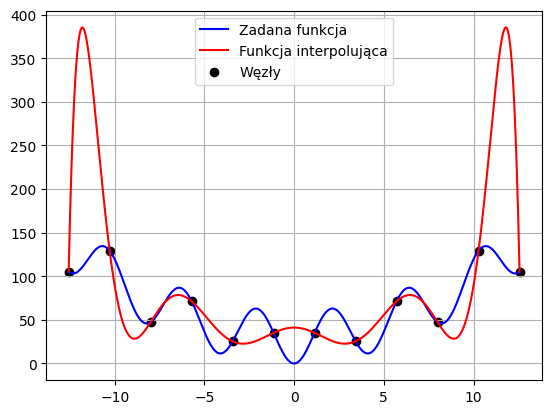

In [47]:
draw_interpolation(lagrange_interpolation, get_evenly_distributed, 12, "img01")

Najlepsze przybliżenie korzystając z interpolacji Newtona i węzłów równoodległych w zakresie [3, 100] ze względu na błąd średniokwadratowy

Przykładowy wykres dla interpolacji lagrange'a i węzłów Czebyszewa

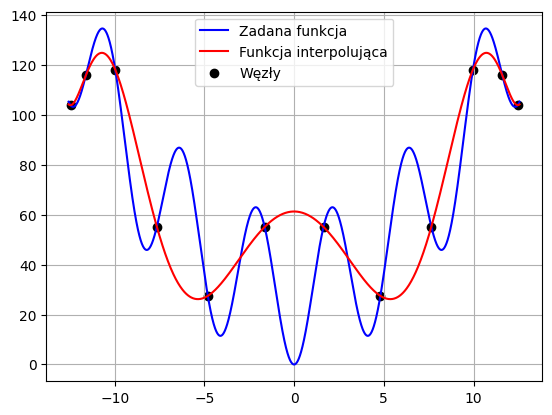

In [48]:
draw_interpolation(lagrange_interpolation, get_chebyshev_nodes, 12, "img02")

Przykładowy wykres dla interpolacji Newtona i równoodległych węzłów

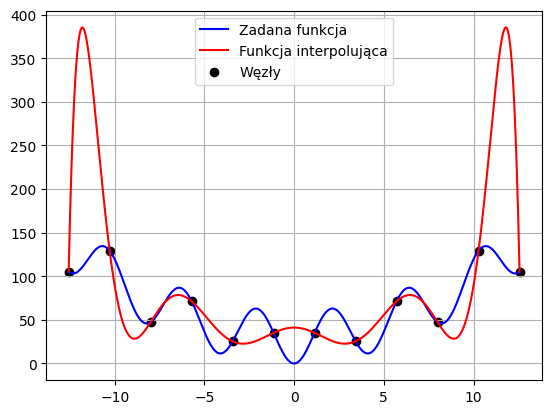

In [49]:
draw_interpolation(newton_interpolation, get_evenly_distributed, 12, "img03")

Przykładowy wykres dla interpolacji Newtona i węzłów Czebyszewa

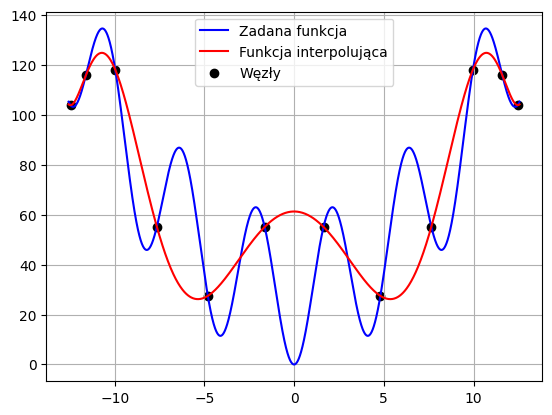

In [50]:
draw_interpolation(newton_interpolation, get_chebyshev_nodes, 12, "img04")

Przykładowy wykres dla interpolacji Hermite'a i równoodległych węzłów

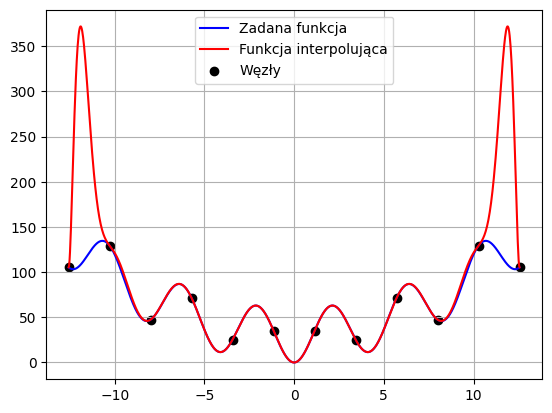

In [51]:
draw_interpolation(hermite_interpolation, get_evenly_distributed, 12, "img05")

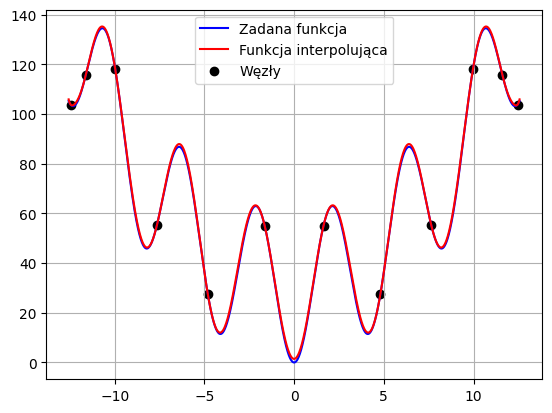

In [52]:
draw_interpolation(hermite_interpolation, get_chebyshev_nodes, 12, "img06")